Módulo: Machine Learning<br>
Professor: Helder Vieira<br>
Data: 12/2021

# Aula 04 - Boosting - Exercício

## Exercício 1

A partir do dataset abaixo, utilize um modelo **LightGBM** para prever, a partir das variáveis de entrada, a probabilidade do individuo receber mais de $50k por ano. Defina um ponto de corte na probabilidade em que, sempre que a probabilidade for maior que o corte, a classe será predita como 1. Otimize os parâmetros do seu modelo utilizando o **GridSearchCV** do sklearn!  

Uma descrição do dataset pode ser encontrada [aqui](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html).  

Ao final do exercício, reporte:  

1 - O tamanho da base utilizada para treino/validação e o tamanho da base utilizada para teste;  
2 - Um gráfico de barras com a importância de cada variável no precesso de predição;  
3 - A acurácia, precisão e recall de treino, validação e teste;  
4 - Uma comparação com o desempenho de um RandomForest padrão do sklearn.  

**Importante**: lembre-se de fazer a divisão do conjunto de teste antes de iniciar o exercício!

### Carregando e visualizando os dados

In [1]:
import pandas as pd

In [2]:
adult_train = pd.read_csv('adult_train.csv')

print(adult_train.shape)
display(adult_train.head())

(39074, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,17,Private,144752,10th,6,Never-married,Handlers-cleaners,Own-child,Amer-Indian-Eskimo,Male,0,0,20,United-States,<=50K
1,21,Local-gov,402230,Some-college,10,Never-married,Adm-clerical,Unmarried,White,Male,0,0,36,United-States,<=50K
2,41,Private,149576,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
3,29,Private,535978,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
4,54,Private,111469,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K


In [3]:
adult_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39074 entries, 0 to 39073
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39074 non-null  int64 
 1   workclass        39074 non-null  object
 2   fnlwgt           39074 non-null  int64 
 3   education        39074 non-null  object
 4   educational-num  39074 non-null  int64 
 5   marital-status   39074 non-null  object
 6   occupation       39074 non-null  object
 7   relationship     39074 non-null  object
 8   race             39074 non-null  object
 9   gender           39074 non-null  object
 10  capital-gain     39074 non-null  int64 
 11  capital-loss     39074 non-null  int64 
 12  hours-per-week   39074 non-null  int64 
 13  native-country   39074 non-null  object
 14  income           39074 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.5+ MB


In [4]:
adult_train.nunique()

age                   74
workclass              9
fnlwgt             24668
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         119
capital-loss          97
hours-per-week        95
native-country        42
income                 2
dtype: int64

### Tratando os dados

In [5]:
categ_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
num_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_train['income'] = adult_train['income'].map({'<=50K': 0, '>50K': 1})

In [6]:
X = adult_train[categ_features + num_features]
y = adult_train['income']

print(X.shape, y.shape)

(39074, 12) (39074,)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=12)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(29305, 12) (29305,)
(9769, 12) (9769,)


In [8]:
from sklearn.preprocessing import OrdinalEncoder
pd.options.mode.chained_assignment = None

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

oe.fit(X_train[categ_features])

X_train[categ_features] = oe.transform(X_train[categ_features])

X_valid[categ_features] = oe.transform(X_valid[categ_features])

X_train.head()

,workclass,marital-status,occupation,relationship,race,gender,native-country,age,educational-num,capital-gain,capital-loss,hours-per-week
19664,0.0,4.0,0.0,3.0,4.0,1.0,38.0,23,9,0,0,40
10815,0.0,4.0,0.0,1.0,4.0,1.0,38.0,28,13,0,0,18
5666,0.0,6.0,0.0,1.0,4.0,0.0,38.0,55,6,0,0,45
16826,7.0,0.0,1.0,4.0,2.0,1.0,38.0,29,10,0,0,40
34840,4.0,4.0,8.0,3.0,4.0,0.0,11.0,19,7,0,0,15


### Modelos

In [9]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

Usamos GridSearchCV para rodar modelos com diferentes combinações de hiperparâmetros, de maneira a podermos selecionar o modelo com a melhor otimização dos parâmetros para o score selecionado.

In [10]:
modelo = LGBMClassifier()

parameters = {
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [20, 50, 70, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'is_unbalance': [True, False]
}

clf = GridSearchCV(modelo, parameters, verbose=2, scoring='recall')

clf.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=20; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=3, n_e

[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=50; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=50; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=50; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.01, max_depth=7, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, le

[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learnin

[CV] END is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=6, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=6, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=6, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=6, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=6, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=0.5, max_depth=6, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning

[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=True, learning_rate=1, max_depth=5, n_

[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=150; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=150; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.01, max_depth=4, n_estimators=150; total time=   0.2s
[CV] END is_unba

[CV] END is_unbalance=False, learning_rate=0.1, max_depth=3, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=3, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=4, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=4, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=4, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=Fal

[CV] END is_unbalance=False, learning_rate=0.1, max_depth=7, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=False, learning_rate=0.1, max_depth=7, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END is_unbalance=False,

[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=20; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=20; total time=   0.0s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=50; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=70; total time=   0.3s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=0.5, max_depth=7, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, l

[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=50; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=70; total time=   0.1s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=70; total time=   0.2s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=150; total time=   0.4s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=False, learning_rate=1, max_depth=6, n_estimators=150; total time=   0.3s
[CV] END is_unbalance=False, learning_rate=1, 

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'is_unbalance': [True, False],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [20, 50, 70, 150]},
             scoring='recall', verbose=2)

In [11]:
# Melhores parametros conforme o gridsearch
clf.best_params_

{'is_unbalance': True,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 50}

In [12]:
# Modelo com parâmetros otimizados
modelo = LGBMClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, is_unbalance=True, importance_type='gain')

modelo

LGBMClassifier(importance_type='gain', is_unbalance=True, max_depth=6,
               n_estimators=50)

In [13]:
# Treino do modelo

modelo.fit(X_train, y_train)

LGBMClassifier(importance_type='gain', is_unbalance=True, max_depth=6,
               n_estimators=50)

In [14]:
# Preditos 
y_train_pred = modelo.predict(X_train)

y_valid_pred = modelo.predict(X_valid)

print(y_train_pred.shape, y_valid_pred.shape)

(29305,) (9769,)


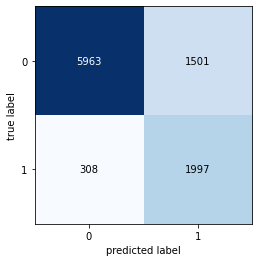

In [15]:
# Matriz de confusão
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_valid, y_valid_pred)

plot_confusion_matrix(conf_mat=cm)
plt.show()

In [16]:
# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc_train = accuracy_score(y_train, y_train_pred)
prec_train = precision_score(y_train, y_train_pred)
rec_train = recall_score(y_train, y_train_pred)

acc_valid = accuracy_score(y_valid, y_valid_pred)
prec_valid = precision_score(y_valid, y_valid_pred)
rec_valid = recall_score(y_valid, y_valid_pred)

print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

Treino:
Acc: 0.83, Precision: 0.60, Recall: 0.90
Validação:
Acc: 0.81, Precision: 0.57, Recall: 0.87


### Teste

In [21]:
adult_test = pd.read_csv('adult_test.csv')
print(adult_test.shape)
display(adult_test.head())

(9768, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
1,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
2,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K
3,65,Private,184454,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,6418,0,40,United-States,>50K
4,37,Private,60548,HS-grad,9,Widowed,Machine-op-inspct,Unmarried,White,Female,0,0,20,United-States,<=50K


In [22]:
# Tratando a target: string para int
adult_test['income'] = adult_test['income'].map({'<=50K':0, '>50K':1})

In [23]:
y_test = adult_test['income'] # target do teste
X_test = adult_test[categ_features + num_features]
X_test[categ_features] = oe.transform(X_test[categ_features])
print(X_test.shape, y_test.shape)

(9768, 12) (9768,)


In [24]:
y_test_pred = modelo.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred)
rec_test = recall_score(y_test, y_test_pred)

print(f'Teste:\nAcc: {acc_test:.4f}, Precision: {prec_test:.4f}, Recall: {rec_test:.4f}')

Teste:
Acc: 0.8183, Precision: 0.5725, Recall: 0.8769


### Retomando

Ao final do exercício, reporte:  

1 - O tamanho da base utilizada para treino/validação e o tamanho da base utilizada para teste;  
2 - Um gráfico de barras com a importância de cada variável no precesso de predição;  
3 - A acurácia, precisão e recall de treino, validação e teste;  
4 - Uma comparação com o desempenho de um RandomForest padrão do sklearn.

In [25]:
print('Tamanho das bases:')
print(f'Treino = {X_train.shape[0]}, validação = {X_valid.shape[0]} e teste = {X_test.shape[0]}')

Tamanho das bases:
Treino = 29305, validação = 9769 e teste = 9768


<Figure size 1152x1152 with 0 Axes>

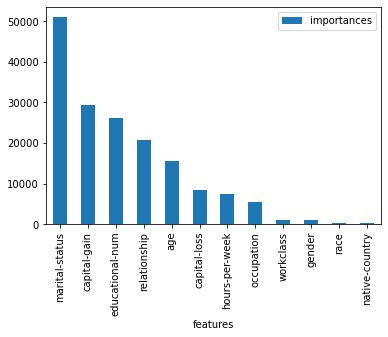

In [19]:
from matplotlib import pyplot as plt

df_importance = pd.DataFrame({
    'features': X_train.columns,
    'importances': modelo.feature_importances_}).sort_values('importances', ascending=False)

plt.figure(figsize=(16, 16))
df_importance.plot.bar(x='features', y='importances');

In [28]:
print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')
print(f'Teste:\nAcc: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}')

Treino:
Acc: 0.83, Precision: 0.60, Recall: 0.90
Validação:
Acc: 0.81, Precision: 0.57, Recall: 0.87
Teste:
Acc: 0.82, Precision: 0.57, Recall: 0.88


#### Árvore de decisão simples

In [29]:
from sklearn.tree import DecisionTreeClassifier

arvore = DecisionTreeClassifier(max_depth=4, min_samples_leaf=15, random_state=23)

arvore.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=15, random_state=23)

In [30]:
y_train_pred_arvore = arvore.predict(X_train)

y_valid_pred_arvore = arvore.predict(X_valid)

In [31]:
acc_train = accuracy_score(y_train, y_train_pred_arvore)
prec_train = precision_score(y_train, y_train_pred_arvore)
rec_train = recall_score(y_train, y_train_pred_arvore)

acc_valid = accuracy_score(y_valid, y_valid_pred_arvore)
prec_valid = precision_score(y_valid, y_valid_pred_arvore)
rec_valid = recall_score(y_valid, y_valid_pred_arvore)

print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

Treino:
Acc: 0.85, Precision: 0.78, Recall: 0.51
Validação:
Acc: 0.84, Precision: 0.77, Recall: 0.49


O desempenho da árvore simples é superior ao do modelo LGBM em termos de acurácia, mas não com relação ao recall. Note que o LGBM foi otimizado em termos do recall.